# VibeMatch GNN Training Notebook

This notebook trains a LightGCN model on music listening data and generates precomputed embeddings for tracks and artists.

## Datasets Used:
- **Spotify Million Playlist Dataset (MPD)**: 1M playlists, 2M+ tracks
- **Last.fm LFM-360K**: 360K users, listening history

## Output:
- `model/lightgcn_mpd_lfm.pt`: Trained model weights
- `model/precomputed_embeddings.pkl`: Track and artist embeddings
- `model/track_artist_mapping.pkl`: Name → ID mappings

In [59]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import LGConv
from torch_geometric.data import Data
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from tqdm import tqdm
import json
import requests
from collections import defaultdict

## 1. Download and Load Datasets

In [60]:
# Cell: Load FMA Dataset (reemplaza la celda de load datasets)

def load_fma_dataset(data_dir="data/fma_metadata"):
    """Load FMA (Free Music Archive) dataset"""
    import ast
    
    # Load tracks with multi-level header
    tracks = pd.read_csv(
        f"{data_dir}/tracks.csv",
        index_col=0,
        header=[0, 1]
    )
    
    # Load genres
    genres = pd.read_csv(f"{data_dir}/genres.csv", index_col=0)
    
    print(f"Loaded {len(tracks)} tracks")
    print(f"Loaded {len(genres)} genres")
    
    # Extract relevant columns
    # FMA has multi-level columns: (category, field)
    track_data = []
    
    for track_id in tqdm(tracks.index, desc="Processing FMA tracks"):
        try:
            title = tracks.loc[track_id, ('track', 'title')]
            artist_name = tracks.loc[track_id, ('artist', 'name')]
            genre_ids = tracks.loc[track_id, ('track', 'genres')]
            
            # Skip if missing essential data
            if pd.isna(artist_name) or pd.isna(title):
                continue
            
            # Parse genre_ids (stored as string representation of list)
            if isinstance(genre_ids, str) and genre_ids != '[]':
                try:
                    genre_list = ast.literal_eval(genre_ids)
                except:
                    genre_list = []
            else:
                genre_list = []
            
            track_data.append({
                'track_id': track_id,
                'track_name': str(title),
                'artist_name': str(artist_name),
                'genre_ids': genre_list
            })
        except Exception as e:
            continue
    
    print(f"Processed {len(track_data)} valid tracks")
    return track_data, genres

## 2. Build Heterogeneous Graph

Graph structure:
- Nodes: Tracks + Artists
- Edges: 
  - Track → Artist (authorship)
  - Track → Track (co-occurrence in playlists)
  - Artist → Artist (collaboration/similarity)

In [61]:
# Cell: Updated MusicGraphBuilder for FMA

class MusicGraphBuilder:
    def __init__(self):
        self.track_to_id = {}
        self.artist_to_id = {}
        self.genre_to_id = {}
        self.edges = defaultdict(list)
        self.track_names = {}  # track_id -> name for lookup
        
    def add_fma_data(self, track_data, genres_df):
        """Add FMA dataset to graph"""
        # Build genre mapping
        for genre_id in genres_df.index:
            if genre_id not in self.genre_to_id:
                self.genre_to_id[genre_id] = len(self.genre_to_id)
        
        # Group tracks by artist for co-occurrence
        artist_tracks = defaultdict(list)
        
        for track in tqdm(track_data, desc="Building graph"):
            track_id = track['track_id']
            artist_name = track['artist_name']
            track_name = track['track_name']
            genre_ids = track['genre_ids']
            
            # Add track node
            if track_id not in self.track_to_id:
                self.track_to_id[track_id] = len(self.track_to_id)
                self.track_names[track_id] = track_name
            
            # Add artist node
            if artist_name not in self.artist_to_id:
                self.artist_to_id[artist_name] = len(self.artist_to_id)
            
            node_track_id = self.track_to_id[track_id]
            node_artist_id = self.artist_to_id[artist_name]
            
            # Track → Artist edge
            self.edges['track_to_artist'].append((node_track_id, node_artist_id))
            
            # Track artist's tracks for co-occurrence
            artist_tracks[artist_name].append(node_track_id)
            
            # Track → Genre edges (for richer graph)
            for genre_id in genre_ids:
                if genre_id in self.genre_to_id:
                    self.edges['track_to_genre'].append((node_track_id, self.genre_to_id[genre_id]))
        
        # Create Track → Track edges (same artist = similar)
        print("Creating track-track edges...")
        for artist, tracks in tqdm(artist_tracks.items()):
            for i, t1 in enumerate(tracks):
                for t2 in tracks[i+1:i+5]:  # Limit connections per track
                    self.edges['track_to_track'].append((t1, t2))
        
        print(f"Graph: {len(self.track_to_id)} tracks, {len(self.artist_to_id)} artists, {len(self.genre_to_id)} genres")
    
    def build_pyg_data(self, embedding_dim=128):
        """Build PyTorch Geometric Data object"""
        num_tracks = len(self.track_to_id)
        num_artists = len(self.artist_to_id)
        num_genres = len(self.genre_to_id)
        total_nodes = num_tracks + num_artists + num_genres
        
        print(f"Total nodes: {total_nodes}")
        
        # Initialize node features
        x = torch.randn(total_nodes, embedding_dim)
        
        # Build edge index
        edge_list = []
        
        # Track-Artist edges (bidirectional)
        for track_id, artist_id in self.edges['track_to_artist']:
            artist_node = num_tracks + artist_id
            edge_list.append([track_id, artist_node])
            edge_list.append([artist_node, track_id])
        
        # Track-Track edges (bidirectional)
        for t1, t2 in self.edges['track_to_track']:
            edge_list.append([t1, t2])
            edge_list.append([t2, t1])
        
        # Artist-Artist similarity edges (bidirectional) - FROM LAST.FM
        for src_id, tgt_id in self.edges['artist_to_artist']:
            src_node = num_tracks + src_id
            tgt_node = num_tracks + tgt_id
            edge_list.append([src_node, tgt_node])
            edge_list.append([tgt_node, src_node])

        print(f"  - Track-Artist: {len(self.edges['track_to_artist']) * 2}")
        print(f"  - Track-Track: {len(self.edges['track_to_track']) * 2}")
        print(f"  - Track-Genre: {len(self.edges['track_to_genre']) * 2}")
        print(f"  - Artist-Artist: {len(self.edges['artist_to_artist']) * 2}")
        
        edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
        
        print(f"Total edges: {edge_index.size(1)}")
        
        data = Data(x=x, edge_index=edge_index)
        
        return data, num_tracks, num_artists, num_genres

In [62]:
# Cell: Load Last.fm Augmented Data

def load_lastfm_augmented(augmented_dir="data/augmented"):
    """Load Last.fm augmented data with genre IDs"""
    import ast
    
    tracks_path = f"{augmented_dir}/lastfm_tracks_formatted.csv"
    edges_path = f"{augmented_dir}/artist_graph_edges.json"
    
    if not Path(tracks_path).exists():
        print(f"⚠️ No augmented data found at {augmented_dir}")
        return [], {'artists': [], 'edges': []}
    
    tracks = pd.read_csv(tracks_path)
    
    with open(edges_path, "r", encoding='utf-8') as f:
        artist_graph = json.load(f)
    
    print(f"Loaded {len(tracks)} Last.fm tracks")
    print(f"Loaded {len(artist_graph['edges'])} artist similarity edges")
    
    # Convert to same format as FMA
    track_data = []
    tracks_with_genres = 0
    
    for _, row in tracks.iterrows():
        # Parse tags
        tags = row['tags']
        if isinstance(tags, str):
            try:
                tags = ast.literal_eval(tags)
            except:
                tags = []
        
        # Parse genre_ids (NEW!)
        genre_ids = row.get('genre_ids', '[]')
        if isinstance(genre_ids, str):
            try:
                genre_ids = ast.literal_eval(genre_ids)
            except:
                genre_ids = []
        
        if genre_ids:
            tracks_with_genres += 1
        
        track_data.append({
            'track_id': row['track_id'],
            'track_name': row['track_name'],
            'artist_name': row['artist_name'],
            'genre_ids': genre_ids,  # Now populated!
            'tags': tags if isinstance(tags, list) else [],
            'source': 'lastfm'
        })
    
    print(f"✅ {tracks_with_genres}/{len(track_data)} Last.fm tracks have genre assignments")
    
    return track_data, artist_graph

In [63]:
# Cell: Build graph with FMA + Last.fm data (MEJORADA)

print("Loading FMA dataset...")
fma_track_data, genres_df = load_fma_dataset("data/fma_metadata")

print("\nLoading Last.fm augmented data...")
lastfm_track_data, artist_graph = load_lastfm_augmented("data/augmented")

# Combine datasets
all_track_data = fma_track_data + lastfm_track_data
print(f"\n✅ Total combined tracks: {len(all_track_data)}")
print(f"   - FMA: {len(fma_track_data)}")
print(f"   - Last.fm: {len(lastfm_track_data)}")

print("\nBuilding music graph...")
graph_builder = MusicGraphBuilder()
graph_builder.add_fma_data(all_track_data, genres_df)

# Create normalized artist lookup for matching
artist_name_normalized = {name.lower().strip(): name for name in graph_builder.artist_to_id.keys()}

# Add artist-artist similarity edges from Last.fm
artist_edges_added = 0
edges_not_found = []

for edge in artist_graph['edges']:
    source_norm = edge['source'].lower().strip()
    target_norm = edge['target'].lower().strip()
    
    source_orig = artist_name_normalized.get(source_norm)
    target_orig = artist_name_normalized.get(target_norm)
    
    if source_orig and target_orig:
        src_id = graph_builder.artist_to_id[source_orig]
        tgt_id = graph_builder.artist_to_id[target_orig]
        graph_builder.edges['artist_to_artist'].append((src_id, tgt_id))
        artist_edges_added += 1
    else:
        edges_not_found.append((edge['source'], edge['target']))

print(f"✅ Added {artist_edges_added} artist-artist similarity edges")
if edges_not_found:
    print(f"⚠️  {len(edges_not_found)} edges skipped (artists not in graph)")

data, num_tracks, num_artists, num_genres = graph_builder.build_pyg_data(embedding_dim=128)
print(f"\n🎵 Graph ready: {data.num_nodes} nodes, {data.edge_index.size(1)} edges")

Loading FMA dataset...
Loaded 106574 tracks
Loaded 163 genres


Processing FMA tracks: 100%|██████████| 106574/106574 [00:48<00:00, 2201.66it/s]


Processed 106573 valid tracks

Loading Last.fm augmented data...
Loaded 24913 Last.fm tracks
Loaded 1571 artist similarity edges
✅ 24587/24913 Last.fm tracks have genre assignments

✅ Total combined tracks: 131486
   - FMA: 106573
   - Last.fm: 24913

Building music graph...


Building graph: 100%|██████████| 131486/131486 [00:00<00:00, 314607.55it/s]


Creating track-track edges...


100%|██████████| 16792/16792 [00:00<00:00, 115644.71it/s]


Graph: 131486 tracks, 16792 artists, 163 genres
✅ Added 1571 artist-artist similarity edges
Total nodes: 148441
  - Track-Artist: 262972
  - Track-Track: 820768
  - Track-Genre: 621714
  - Artist-Artist: 3142
Total edges: 1086882

🎵 Graph ready: 148441 nodes, 1086882 edges


## 3. Define LightGCN Model

In [64]:
class LightGCN(torch.nn.Module):
    """LightGCN for music recommendation"""
    
    def __init__(self, num_nodes, embedding_dim=128, num_layers=3):
        super().__init__()
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        
        # Learnable embeddings
        self.embedding = torch.nn.Embedding(num_nodes, embedding_dim)
        
        # LightGCN layers
        self.convs = torch.nn.ModuleList([
            LGConv() for _ in range(num_layers)
        ])
        
        self.reset_parameters()
    
    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.embedding.weight)
    
    def forward(self, edge_index):
        x = self.embedding.weight
        
        # Layer-wise propagation
        embeddings = [x]
        for conv in self.convs:
            x = conv(x, edge_index)
            embeddings.append(x)
        
        # Average all layers
        final_embedding = torch.mean(torch.stack(embeddings), dim=0)
        
        return final_embedding

## 4. Train Model

In [65]:
# Training configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
model = LightGCN(
    num_nodes=data.num_nodes,
    embedding_dim=128,
    num_layers=3
).to(device)

data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [66]:
def train_epoch(model, data, optimizer, num_samples=10000, reg_weight=1e-5):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    embeddings = model(data.edge_index)
    
    # Sample positive edges
    perm = torch.randperm(data.edge_index.size(1), device=device)[:num_samples]
    pos_edges = data.edge_index[:, perm]
    
    # Positive scores
    pos_scores = (embeddings[pos_edges[0]] * embeddings[pos_edges[1]]).sum(dim=1)
    
    # Hard negative sampling: sample more negatives and pick hardest
    num_neg_candidates = num_samples * 5
    neg_candidates = torch.randint(0, data.num_nodes, (2, num_neg_candidates), device=device)
    neg_scores_all = (embeddings[neg_candidates[0]] * embeddings[neg_candidates[1]]).sum(dim=1)
    
    # Select top-k hardest negatives (highest scores)
    _, hard_neg_idx = torch.topk(neg_scores_all, num_samples)
    neg_scores = neg_scores_all[hard_neg_idx]
    
    # BPR loss with margin
    margin = 0.5
    loss = torch.clamp(margin - pos_scores + neg_scores, min=0).mean()
    
    # L2 regularization on embeddings (prevents overfitting)
    reg_loss = reg_weight * (embeddings ** 2).mean()
    
    total_loss = loss + reg_loss
    
    total_loss.backward()
    optimizer.step()
    
    return loss.item(), reg_loss.item()

In [67]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Training configuration
num_epochs = 500
patience = 20
best_loss = float('inf')
patience_counter = 0

# Scheduler: reduce LR when loss plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

loss_history = []

for epoch in tqdm(range(num_epochs)):
    loss, reg_loss = train_epoch(model, data, optimizer, num_samples=15000, reg_weight=1e-5)
    loss_history.append(loss)
    
    # Update scheduler
    scheduler.step(loss)
    
    # Early stopping check
    if loss < best_loss - 0.001:  # Minimum improvement threshold
        best_loss = loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), "model/lightgcn_best.pt")
    else:
        patience_counter += 1
    
    if (epoch + 1) % 20 == 0:
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Reg: {reg_loss:.6f}, LR: {lr:.6f}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(torch.load("model/lightgcn_best.pt"))
print(f"\nBest loss: {best_loss:.4f}")

  4%|▍         | 20/500 [00:05<02:56,  2.71it/s]

Epoch 20/500, Loss: 0.4876, Reg: 0.000000, LR: 0.001000


  8%|▊         | 40/500 [00:13<03:05,  2.48it/s]

Epoch 40/500, Loss: 0.4238, Reg: 0.000000, LR: 0.001000


 12%|█▏        | 60/500 [00:21<02:56,  2.49it/s]

Epoch 60/500, Loss: 0.2946, Reg: 0.000000, LR: 0.001000


 16%|█▌        | 80/500 [00:29<02:48,  2.50it/s]

Epoch 80/500, Loss: 0.1374, Reg: 0.000000, LR: 0.001000


 20%|██        | 101/500 [00:38<01:46,  3.74it/s]

Epoch 100/500, Loss: 0.0527, Reg: 0.000000, LR: 0.001000


 24%|██▍       | 121/500 [00:43<01:11,  5.33it/s]

Epoch 120/500, Loss: 0.0333, Reg: 0.000000, LR: 0.001000


 28%|██▊       | 141/500 [00:46<00:53,  6.69it/s]

Epoch 140/500, Loss: 0.0227, Reg: 0.000000, LR: 0.001000


 32%|███▏      | 161/500 [00:50<00:47,  7.09it/s]

Epoch 160/500, Loss: 0.0173, Reg: 0.000000, LR: 0.001000


 36%|███▌      | 181/500 [00:53<00:40,  7.82it/s]

Epoch 180/500, Loss: 0.0142, Reg: 0.000000, LR: 0.001000


 40%|████      | 201/500 [00:56<00:38,  7.69it/s]

Epoch 200/500, Loss: 0.0113, Reg: 0.000000, LR: 0.001000


 44%|████▍     | 221/500 [00:59<00:35,  7.88it/s]

Epoch 220/500, Loss: 0.0105, Reg: 0.000000, LR: 0.001000


 48%|████▊     | 241/500 [01:01<00:33,  7.81it/s]

Epoch 240/500, Loss: 0.0091, Reg: 0.000000, LR: 0.001000


 52%|█████▏    | 261/500 [01:04<00:30,  7.96it/s]

Epoch 260/500, Loss: 0.0083, Reg: 0.000000, LR: 0.001000


 53%|█████▎    | 263/500 [01:05<00:58,  4.04it/s]


Early stopping at epoch 264

Best loss: 0.0074


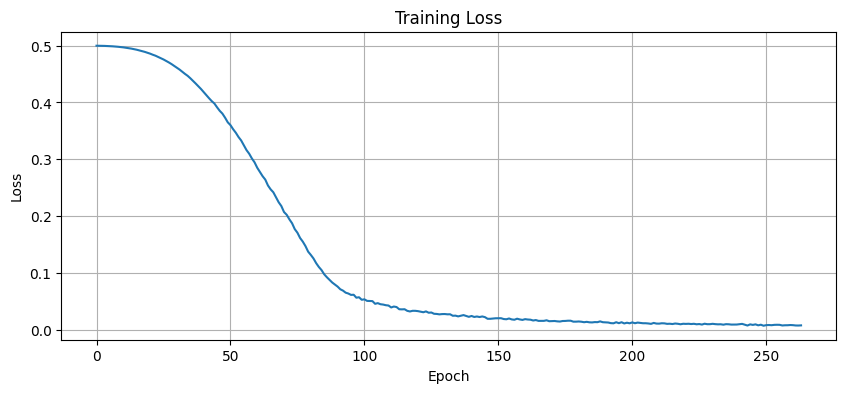

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.savefig('model/training_loss.png')
plt.show()

## 5. Extract and Save Embeddings

In [69]:
# Generate final embeddings
model.eval()
with torch.no_grad():
    final_embeddings = model(data.edge_index).cpu().numpy()

# Split into tracks, artists, and genres correctly
track_embeddings_array = final_embeddings[:num_tracks]
artist_embeddings_array = final_embeddings[num_tracks:num_tracks + num_artists]
genre_embeddings_array = final_embeddings[num_tracks + num_artists:]

print(f"Track embeddings shape: {track_embeddings_array.shape}")
print(f"Artist embeddings shape: {artist_embeddings_array.shape}")
print(f"Genre embeddings shape: {genre_embeddings_array.shape}")

Track embeddings shape: (131486, 128)
Artist embeddings shape: (16792, 128)
Genre embeddings shape: (163, 128)


In [70]:
# Create lookups: name -> embedding
track_embeddings = {}
for track_id, node_id in graph_builder.track_to_id.items():
    # Use track name as key for easier lookup
    track_name = graph_builder.track_names.get(track_id, str(track_id))
    normalized_name = track_name.lower().strip()
    track_embeddings[normalized_name] = track_embeddings_array[node_id]
    # Also store by ID
    track_embeddings[f"fma:{track_id}"] = track_embeddings_array[node_id]

artist_embeddings = {}
for artist_name, artist_id in graph_builder.artist_to_id.items():
    normalized_name = artist_name.lower().strip()
    artist_embeddings[normalized_name] = artist_embeddings_array[artist_id]

print(f"Created {len(track_embeddings)} track embeddings")
print(f"Created {len(artist_embeddings)} artist embeddings")

Created 245117 track embeddings
Created 16788 artist embeddings


In [71]:
# Save model
torch.save(model.state_dict(), "model/lightgcn_mpd_lfm.pt")
print("Saved model to model/lightgcn_mpd_lfm.pt")

# Save embeddings
with open("model/precomputed_embeddings.pkl", "wb") as f:
    pickle.dump({
        "track_embeddings": track_embeddings,
        "artist_embeddings": artist_embeddings
    }, f)
print("Saved embeddings to model/precomputed_embeddings.pkl")

# Save mappings
with open("model/track_artist_mapping.pkl", "wb") as f:
    pickle.dump({
        "track_to_id": graph_builder.track_to_id,
        "artist_to_id": graph_builder.artist_to_id
    }, f)
print("Saved mappings to model/track_artist_mapping.pkl")

Saved model to model/lightgcn_mpd_lfm.pt
Saved embeddings to model/precomputed_embeddings.pkl
Saved mappings to model/track_artist_mapping.pkl


## 6. Verification

In [75]:
# Test similarity
def cosine_similarity(emb1, emb2):
    return np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))

# Verificar estadísticas de embeddings
print("=== Embedding Statistics ===")
print(f"Track embeddings: {len(track_embeddings)}")
print(f"Artist embeddings: {len(artist_embeddings)}")
print(f"Embedding dimension: {list(artist_embeddings.values())[0].shape}")

# Calcular distribución de similitudes
import random
sample_artists = random.sample(list(artist_embeddings.keys()), min(100, len(artist_embeddings)))
all_sims = []
for i, a1 in enumerate(sample_artists):
    for a2 in sample_artists[i+1:]:
        sim = cosine_similarity(artist_embeddings[a1], artist_embeddings[a2])
        all_sims.append(sim)

print(f"\n=== Similarity Distribution (sample of {len(all_sims)} pairs) ===")
print(f"Mean: {np.mean(all_sims):.4f}")
print(f"Std: {np.std(all_sims):.4f}")
print(f"Min: {np.min(all_sims):.4f}")
print(f"Max: {np.max(all_sims):.4f}")

# Find similar artists (usando un artista aleatorio)
test_artist = random.choice(list(artist_embeddings.keys()))
test_emb = artist_embeddings[test_artist]

similarities = []
for artist, emb in artist_embeddings.items():
    if artist != test_artist:
        sim = cosine_similarity(test_emb, emb)
        similarities.append((artist, sim))

top_similar = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]
print(f"\n=== Most similar to '{test_artist}' ===")
for artist, sim in top_similar:
    print(f"  {artist}: {sim:.4f}")

=== Embedding Statistics ===
Track embeddings: 245117
Artist embeddings: 16788
Embedding dimension: (128,)

=== Similarity Distribution (sample of 4950 pairs) ===
Mean: -0.0015
Std: 0.0879
Min: -0.3244
Max: 0.2986

=== Most similar to 'l.g.t.a.i.d.l.e. antenne drôme' ===
  waco brothers: 0.3533
  elbee: 0.3209
  new found land: 0.3169
  grouper: 0.3111
  ending satellites: 0.3095


In [76]:
# Celda: Verificar artistas Last.fm específicos

print("=" * 60)
print("🎵 Testing Last.fm Artists Similarity")
print("=" * 60)

test_artists = [
    "kanye west", "radiohead", "the weeknd", "mac demarco", 
    "lana del rey", "my chemical romance", "the killers",
    "green day", "weezer", "post malone"
]

for test_artist in test_artists:
    if test_artist in artist_embeddings:
        test_emb = artist_embeddings[test_artist]
        
        similarities = []
        for artist, emb in artist_embeddings.items():
            if artist != test_artist:
                sim = cosine_similarity(test_emb, emb)
                similarities.append((artist, sim))
        
        top_similar = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]
        print(f"\n🎵 '{test_artist}':")
        for artist, sim in top_similar:
            print(f"   {artist}: {sim:.4f}")
    else:
        print(f"\n❌ '{test_artist}' NOT FOUND")

print("\n" + "=" * 60)

🎵 Testing Last.fm Artists Similarity

🎵 'kanye west':
   kanye west, big sean, pusha t & 2 chainz: 0.3588
   botinki ra: 0.3390
   northbound: 0.3270
   chtin mara with bad poet and marrach: 0.3262
   joëlle léandre: 0.3067

🎵 'radiohead':
   bob ostertag with fred frith, charles k. noyes and bryan medwed: 0.3600
   rojuu: 0.3378
   so far as i know: 0.3165
   everybody was in the french resistance...now!: 0.3119
   wild carnation: 0.3067

🎵 'the weeknd':
   ben seretan and alex lewis: 0.3368
   familia wanderstaff: 0.3288
   irving kaufmann: 0.3238
   big jip: 0.3072
   autistic daughters: 0.3071

🎵 'mac demarco':
   tv girl: 0.4867
   ñuca llacta: 0.3339
   current joys: 0.3315
   lucas kuzma: 0.3280
   kid flicks: 0.3113

🎵 'lana del rey':
   potzrebowski, mcmillan and co.: 0.3412
   the yummy fur: 0.3074
   secret lover: 0.3072
   alex waterman, dafna naphtali and darius jones: 0.3056
   selena gomez, benny blanco & the marías: 0.3009

🎵 'my chemical romance':
   fall out boy: 0.45

## Done!

The model and embeddings are now ready to use in the VibeMatch API.

Next steps:
1. Copy the `model/` directory to your backend
2. The API will load these embeddings automatically
3. Run the ghost user seeding script